In [261]:
import pandas as pd
import folium
import fiona
import geopandas as gpd
import requests
import numpy as np
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from shapely.geometry import Polygon
from math import pi, sin, cos
from geojson import GeoJSON

In [6]:
key_path = "C:\\Users\\John\\Documents\\notGitHub\\API_key.txt"
key_file = open(key_path, 'r')
api_key = key_file.readline()

In [227]:
string1 = "https://mobilityscore.transitscreen.io/api"
string2 = "/v1/locations.json?coordinates="
string3 = "&key="
string4 = "&geojson=true"

def get_location(lat, long):
    cords = str(lat)+","+str(long)
    new_string = string1+string2+cords+string3+api_key+string4
    return requests.get(new_string)


# def get_row(lat, long):
#     sample = get_location(lat, long).json()['data']['mobilityScore']
#     row = pd.DataFrame([[lat,long]],columns=['Latitude','Longitude'], index=[0])
# #     return sample, row
#     row['score']=sample['score']
#     breakdown = pd.DataFrame(sample['scoreBreakdown'], index=[0])
#     row = row.merge(breakdown, left_index=True, right_index=True)
#     return row

def extract_scores(api_response):
    sample = api_response.json()['data']['mobilityScore']
    score=sample['score']
    breakdown = pd.DataFrame(sample['scoreBreakdown'], index=[0]).values
    return {'score':score,
            'bikeshare':breakdown[0][0],
            'carshare':breakdown[0][0],
            'masstransit':breakdown[0][1],
            'ridehailing':breakdown[0][2]
           }

In [198]:
washington_x = 38.904978
washginton_y = -77.039658

washington_boundaries = (
(washington_x-0.15, washginton_y-0.15),
(washington_x+0.15, washginton_y+0.15)
)

washington = folium.Map()
washington.fit_bounds(washington_boundaries)

def single_hex(x, y, r):
    verts = []
    for i in range(6):
        angle = i * 2 * pi / 6
        xc = x + cos(angle) * r
        yc = y + sin(angle) * r
        verts.append((xc, yc))
    return verts


def make_grid(center, radius_count, hex_radius):
    results = []
    hex_list = []
    hex_list.append(single_hex(center[0],center[1], hex_radius))
    for n in range(1,radius_count,1): # get the corner hexes of a band this distance from center
        c2c = n*2*hex_radius*sin(pi/3) # distance of center of these verts from overall center
        verts = []
        for m in range(6):
            angle = ((m/6)-(1/12)) * (2.0*pi)
            v_x = center[0] + cos(angle)*c2c # coordinates of one of the six corner hexes
            v_y = center[1] + sin(angle)*c2c
#             hex_list.append(single_hex(v_x,v_y,hex_radius))
#             band_centers.append((v_x,v_y))
#             folium.Circle(np.array([v_x,v_y]), fill_color='#43d9de', radius=8).add_to(washington)
            verts.append((v_x, v_y))
        for i,this_hex in enumerate(verts):# fill in the hexes between the corners
            next_hex = verts[(i+1)%6] # next corner going around counterclockwise, back to sh
            centers = []
            side_length = n
            gap_x = (next_hex[0]-this_hex[0])/side_length
            gap_y = (next_hex[1]-this_hex[1])/side_length
            for j in range(side_length):
                x_coord = this_hex[0]+gap_x*j
                y_coord = this_hex[1]+gap_y*j
                hex_list.append(single_hex(x_coord,y_coord,hex_radius))
                
                
#             x_coords = range(this_hex[0],next_hex[0],side_length)
#             y_coords = range(this_hex[1],next_hex[1],side_length)
#             for x_c, y_c in zip(x_coords[:-1],y_coords[:-1]):
#                 hex_list.append((x_c,y_c,hex_radius))
            
    for hex_cords in hex_list:
        results.append(Polygon(hex_cords))
#         poly = folium.PolyLine(locations=np.array(hex_cords), weight=1)
#         washington.add_child(poly, name="Nobody", index=0)
    return results
    
hex_frame = gpd.GeoDataFrame(make_grid((x,y), 20, 0.005), columns=['geometry'])  
hex_frame['Centroid']=hex_frame['geometry'].apply(lambda poly: poly.centroid)

In [212]:
hex_frame['Center_Info'] = hex_frame.Centroid.apply(lambda centroid: get_location(centroid.x, centroid.y))


In [213]:
hex_frame.head()

,Polygon,Centroid,Center_Info
0,"POLYGON ((38.91220000000001 -77.0369, 38.9097 ...",POINT (38.9072 -77.03690000000002),<Response [200]>
1,POLYGON ((38.91970000000001 -77.04123012701892...,POINT (38.9147 -77.04123012701893),<Response [200]>
2,POLYGON ((38.91970000000001 -77.03256987298109...,POINT (38.9147 -77.0325698729811),<Response [200]>
3,POLYGON ((38.91220000000001 -77.02823974596215...,POINT (38.9072 -77.02823974596215),<Response [200]>
4,POLYGON ((38.90470000000001 -77.03256987298109...,POINT (38.8997 -77.0325698729811),<Response [200]>


In [229]:
hex_frame['results'] = hex_frame['Center_Info'].apply(extract_scores)

In [230]:
hex_frame.head()

,Polygon,Centroid,Center_Info,results
0,"POLYGON ((38.91220000000001 -77.0369, 38.9097 ...",POINT (38.9072 -77.03690000000002),<Response [200]>,"{'score': 100, 'bikeshare': '10%', 'carshare':..."
1,POLYGON ((38.91970000000001 -77.04123012701892...,POINT (38.9147 -77.04123012701893),<Response [200]>,"{'score': 85, 'bikeshare': '14%', 'carshare': ..."
2,POLYGON ((38.91970000000001 -77.03256987298109...,POINT (38.9147 -77.0325698729811),<Response [200]>,"{'score': 88, 'bikeshare': '14%', 'carshare': ..."
3,POLYGON ((38.91220000000001 -77.02823974596215...,POINT (38.9072 -77.02823974596215),<Response [200]>,"{'score': 94, 'bikeshare': '11%', 'carshare': ..."
4,POLYGON ((38.90470000000001 -77.03256987298109...,POINT (38.8997 -77.0325698729811),<Response [200]>,"{'score': 100, 'bikeshare': '10%', 'carshare':..."


In [237]:
hex_frame['score'] = hex_frame['results'].apply(lambda d: d['score'])

In [291]:
hex_frame['index1'] = hex_frame.index
hex_frame.head()

,geometry,Centroid,Center_Info,results,score,index1
0,"POLYGON ((38.91220000000001 -77.0369, 38.9097 ...",POINT (38.9072 -77.03690000000002),<Response [200]>,"{'score': 100, 'bikeshare': '10%', 'carshare':...",100,0
1,POLYGON ((38.91970000000001 -77.04123012701892...,POINT (38.9147 -77.04123012701893),<Response [200]>,"{'score': 85, 'bikeshare': '14%', 'carshare': ...",85,1
2,POLYGON ((38.91970000000001 -77.03256987298109...,POINT (38.9147 -77.0325698729811),<Response [200]>,"{'score': 88, 'bikeshare': '14%', 'carshare': ...",88,2
3,POLYGON ((38.91220000000001 -77.02823974596215...,POINT (38.9072 -77.02823974596215),<Response [200]>,"{'score': 94, 'bikeshare': '11%', 'carshare': ...",94,3
4,POLYGON ((38.90470000000001 -77.03256987298109...,POINT (38.8997 -77.0325698729811),<Response [200]>,"{'score': 100, 'bikeshare': '10%', 'carshare':...",100,4


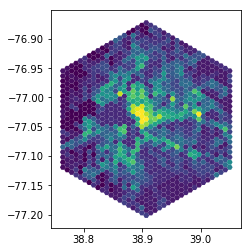

In [320]:
hex_frame.to_pickle('hex_pickle')
hex_frame.plot(column='score')